Last updated 2020-02-03

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

from clf_eval_utils import quickplot_eval_3, quickplot_eval_4

import shap

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load NHFES data

Available for download at https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1268/1268/20/nhefs.csv

In [2]:
full_data = pd.read_csv(os.path.join('data','nhefs.csv'))
full_data.drop(['yrdth','modth','dadth'], axis=1, inplace=True)
full_data.dropna(axis=1,inplace=True)
full_data.head()

,seqn,qsmk,death,sex,age,race,marital,school,education,ht,...,allergies,nerves,lackpep,hbpmed,boweltrouble,wtloss,infection,active,exercise,birthcontrol
0,233,0,0,0,42,1,2,7,1,174.1875,...,0,0,0,1,0,0,0,0,2,2
1,235,0,0,0,36,0,2,9,2,159.3750,...,0,0,0,0,0,0,1,0,0,2
2,244,0,0,1,56,1,3,11,2,168.5000,...,0,1,0,0,0,0,0,0,2,0
3,245,0,1,0,68,1,3,5,1,170.1875,...,0,0,0,0,0,0,0,1,2,2
4,252,0,0,0,40,0,2,11,2,181.8750,...,0,0,0,0,1,0,0,1,1,2


In [3]:
data_desc = pd.read_excel(os.path.join('data','NHEFS_Codebook.xls'))
data_desc_dict = pd.Series(index=data_desc['Variable name'], data=data_desc['Description'].values).to_dict()
data_desc.head()

,Variable name,Description
0,active,"IN YOUR USUAL DAY, HOW ACTIVE ARE YOU? IN 1971..."
1,age,AGE IN 1971
2,alcoholfreq,HOW OFTEN DO YOU DRINK? IN 1971 0: Almost ev...
3,alcoholhowmuch,"WHEN YOU DRINK, HOW MUCH DO YOU DRINK? IN 1971"
4,alcoholpy,"HAVE YOU HAD 1 DRINK PAST YEAR? IN 1971, 1:EV..."


# Split train\test

In [4]:
data_train, data_test = train_test_split(full_data, test_size=0.3)
print(f'Train: {data_train.shape}, Test: {data_test.shape}')\

X_train, y_train = data_train.loc[:, data_train.columns!='death'], data_train.loc[:, 'death']
X_test, y_test = data_test.loc[:, data_test.columns!='death'], data_test.loc[:, 'death']

Train: (1140, 45), Test: (489, 45)


# Predict

In [5]:
clf = GradientBoostingClassifier(n_estimators=40, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)

y_pred_train = clf.predict_proba(X_train)[:,1]
y_pred_test = clf.predict_proba(X_test)[:,1]

print(f'Train AUC: {roc_auc_score(y_train,y_pred_train)}')
print(f'Test AUC: {roc_auc_score(y_test,y_pred_test)}')

Train AUC: 0.8770648796892156
Test AUC: 0.8174968440984642


# Eval

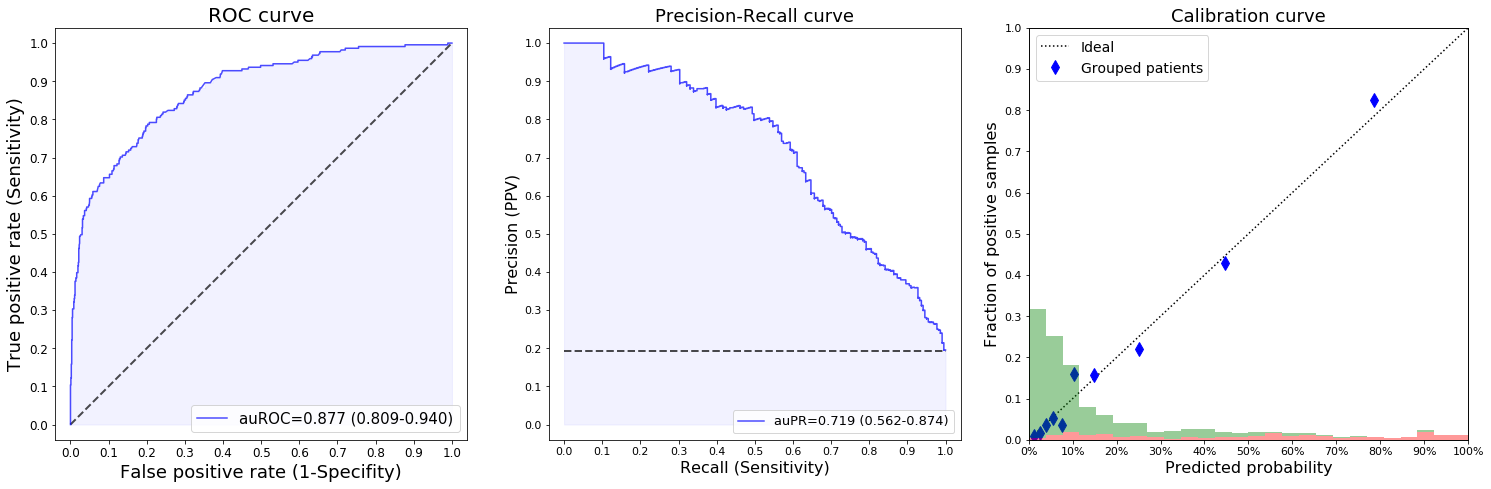

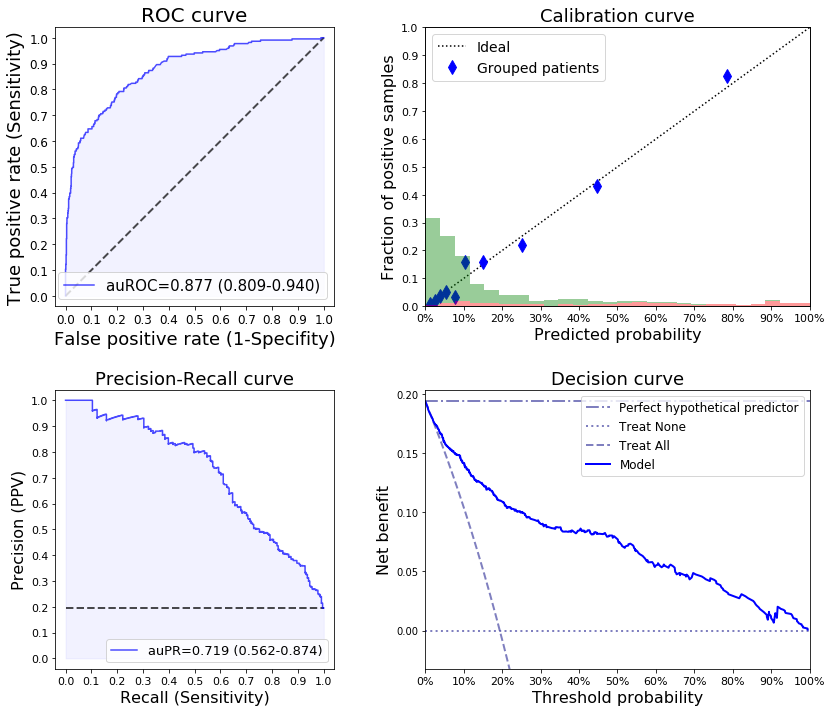

In [6]:
y_true = y_train
y_pred = y_pred_train

quickplot_eval_3(y_true, y_pred)

quickplot_eval_4(y_true, y_pred)

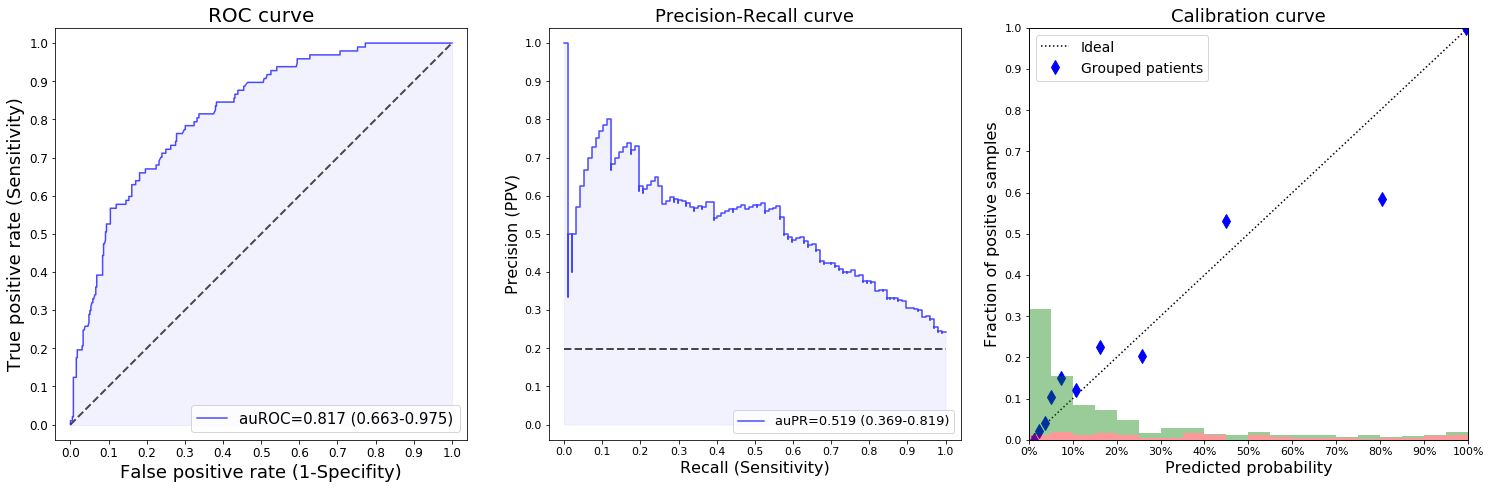

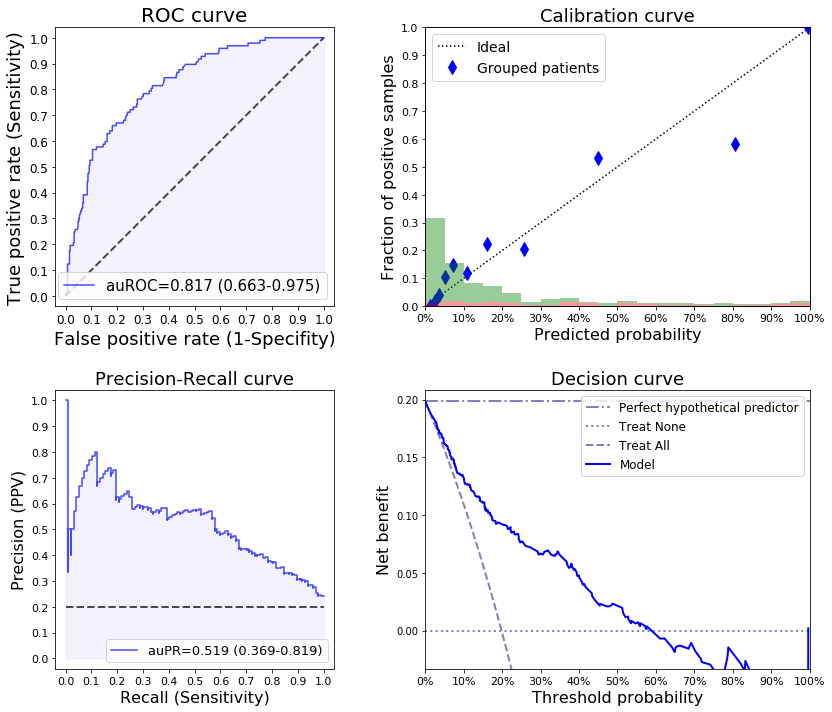

In [7]:
y_true = y_test
y_pred = y_pred_test

quickplot_eval_3(y_true, y_pred)

quickplot_eval_4(y_true, y_pred)

# simple SHAP

In [8]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


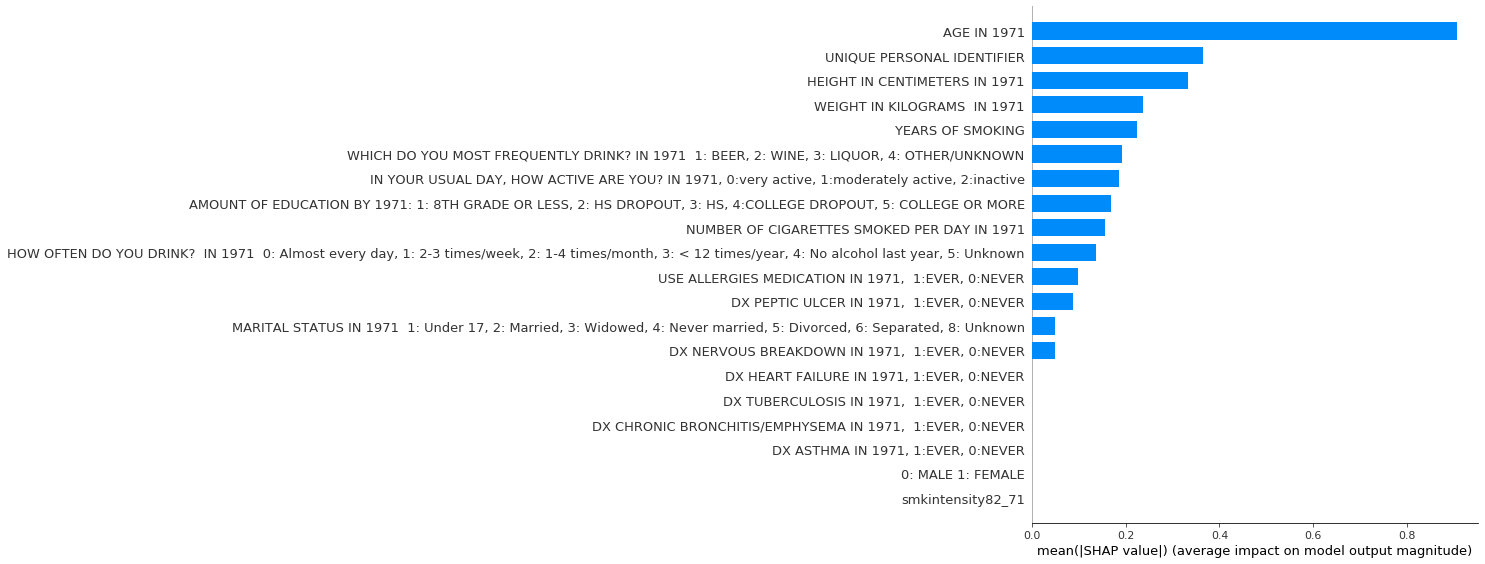

In [9]:
shap.summary_plot(shap_values, X_train.rename(columns=data_desc_dict), plot_type='bar')

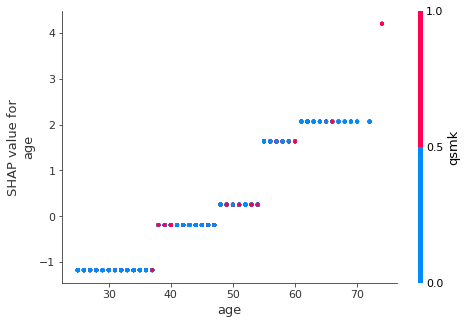

In [11]:
shap.dependence_plot(X_train.columns.get_loc('age'), shap_values, X_train)

# Custom SHAP plots

In [39]:
from scipy.special import expit


def convert_shap_values(y, base_shap, y_transform=None):
    """
   Transform SHAP values from log-odds scale to other scales
    
    Parameters
    ----------
    y: shap_values array
    base_shap: For use with convert_to_risk. Available through 
        shap.TreeExplainer(predictor).expected_value
    y_transform: transformation of the logodds SHAP vlaues to one of the following:
                'relative risk', 'odds', 'probability', or log relative risk'
                
    Returns
    -------
    y, y_lbl: transformed y and the corresponding label of the transform
    
    """
    
    # Convert y
    if y_transform=='log odds':
        # retain original SHAP value in y (log Odds)
        y_lbl = 'Shapely Value'
    elif y_transform=='relative risk':
        y_lbl = 'Relative Risk'
        y = expit(base_shap+y)/expit(base_shap)
    elif y_transform=='odds':
        y_lbl = 'Odds'
        y = np.exp(y)
    elif y_transform=='probability':
        y_lbl = 'Probabilty'
        tmp = np.exp(y)
        y = tmp/(1+tmp)
    elif y_transform=='log relative risk':
        y_lbl = 'Log Relative Risk'
        y = np.log(expit(base_shap+y)/expit(base_shap))
    else:
        y_lbl = 'Shapely Value'
    return y, y_lbl


def _add_bottom_hist(ax, x, bins=None, hist_color='k'):
    ax2 = ax.twinx()
    sns.distplot(x, bins=bins, kde=False, norm_hist=True,
                 ax=ax2, hist_kws={'alpha':0.2}, color=hist_color)
    # Visuals
    ax2.get_yaxis().set_visible(False)
    # make room in the bottom of original plot
    ax.set_ylim(ax.get_ylim()[0] - ((ax.get_ylim()[1] - ax.get_ylim()[0])*0.25), ax.get_ylim()[1])
    # shrink histogram height
    ax2.set_ylim(ax2.get_ylim()[0], ax2.get_ylim()[1]*5)
    

def dep_plot(feature_name, shap_values, features, shap_columns=None, ax=None,
             feature_text=None, shap_text=None,
             base_shap=None, y_transform=None, add_nan=False, nan_label='NaN',
             x_min=None, x_max=None, x_round=None, manual_bins=None,
             x_quantile_min=None, x_quantile_max=None,
             plot_hist=True, plot_type=None,
             SZ=16, color=sns.color_palette()[0], hist_color='k'):
    """
    Custom version of SHAP's dependence plot
    
    Parameters
    ----------
    feature_name: relevant column in features and in shap_values
    shap_values: SHAP values numpy array
    features: pandas dataframe of X
    shap_columns: if sum of multiple shap columns is wanted on the y axis
    ax: axis
    feature_text: xlabel
    shap_text: ylabel
    base_shap: For use with convert_to_risk. Available through 
        shap.TreeExplainer(predictor).expected_value
    y_transform: transformation of the logodds SHAP vlaues to one of the following:
                'relative risk', 'odds', 'probability', or log relative risk'
    add_nan: add shap values for nan features on the left of the plot
    nan_label: label on x axis for nans
    x_min, x_max: minimal/maximal feature value to plot
    x_round: rounding order of magnitude. It is advised to use some rounding in continuous features
    manual_bins: set manual bins for plotting lineplot width 
    x_quantile_min, x_quantile_max: filter min/max feature value by feature quantile given here
    plot_hist: plot feature value histogram at bottom of plot
    plot_type: None plots bands from std in bins. 'scatter' plots all datapoints in a scatterplot
    SZ: label fontsize
    color: color
    hist_color: color for histogram    
    
    Examples of usage:
    -----------------   
    TBD
    
    """
    # Make shap_values a Dataframe with named columns
    shap_values = pd.DataFrame(data=shap_values, columns=features.columns)
    
    if ax is None:
        ax = plt.gca()
    
    # Define xy for plotting
    x_raw = features[feature_name].rename('x')
    #copy original x for processing
    x = x_raw
    # y can be summed from multiple columns or not
    if shap_columns is None:
        y = shap_values[feature_name].rename('y')
    else:
        y = shap_values[shap_columns].sum(axis=1).rename('y')
    
    # Transform y according to inputs
    y, y_lbl = convert_shap_values(y, base_shap, y_transform)
    
    # Alter x according to inputs
    if x_quantile_max is not None:
        x = x[x <= x.quantile(x_quantile_max)]
    if x_quantile_min is not None:
        x = x[x >= x.quantile(x_quantile_min)]
    if x_min is not None:
        x = x[(x>=x_min)]
    if x_max is not None:
        x = x[(x<=x_max)]
    if x_round is not None:
        # round x points
        x = x.round(x_round)
   
    # For given manual bins of x
    if ((x_round is None) & (manual_bins is not None)):
        # if a single number N is given, then build N bins
        if type(manual_bins)==int:
            # create bins 
            cuts, bins = pd.cut(x, bins=manual_bins, retbins=True)
        # if a list is given, then build bins from list
        else:
            bins = manual_bins
        bins_mid_x = np.array([(a+b)/2 for a,b, in zip(bins[:-1], bins[1:])])
        # find closest bin middle and transform x
        x = x.apply(lambda xx: bins_mid_x[np.abs(xx-bins_mid_x).argmin()])
        
    # Plot type
    if plot_type=='lineplot':
        sns.lineplot(data=pd.concat((x,y),axis=1),x='x',y='y',ci=None,color=color, ax=ax)
        ax.get_legend().remove()
    else:
        ax.scatter(x_raw, y, s=8, color=color, alpha=0.1)
    
    if feature_text is not None:
        xlabel = feature_text
    else:
        xlabel = "Feature Value"
        
    if shap_text is None:
        ylabel = y_lbl
    else:
        ylabel =  f'{y_lbl} for {shap_text}'
    
    # Adjust plot
    ax.set_xlabel(xlabel, size=SZ)
    ax.set_ylabel(ylabel, size=SZ)
    sns.despine(right=True,top=True,bottom=False, ax=ax)
    ax.set_xlim(x.min(), x.max())    
    if y_transform=='relative risk':
        ax.axhline(y=1.0, color='k', ls='--', lw=1, alpha=0.4)
    
    # plot bottom histogram if required  
    if plot_hist:
        _add_bottom_hist(ax, x, bins=manual_bins, hist_color=hist_color)
    
    # Add NaN item if requested
    if add_nan:
        
        if shap_columns is None:
            y_nan = shap_values[feature_name][features[feature_name].isna()].rename('y')
        else:
            y_nan = shap_values[shap_columns].sum(axis=1)[features[feature_name].isna()].rename('y')
        y_nan, _ = _convert_shap_values(y_nan, base_shap, y_transform)
        
        xlim = ax.get_xlim()
        xticks = ax.get_xticks()
        xticklabels = ax.get_xticklabels()
        x_nan = [xlim[0]-0.06*(xlim[1]-xlim[0]),xlim[0]-0.01*(xlim[1]-xlim[0])]
        xticklabels = [nan_label]+[str(item) for item in xticks[1:]]
        xticks = [(x_nan[0]+x_nan[1])/2]+list(xticks)[1:]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
        ax.plot(x_nan,[y_nan.mean(),y_nan.mean()],color=color, lw=2)
        ax.fill_between(x_nan,
                         [y_nan.mean()-y_nan.std(),y_nan.mean()-y_nan.std()],
                         [y_nan.mean()+y_nan.std(),y_nan.mean()+y_nan.std()],alpha=0.1,color=color)
        ax.axvline(xlim[0], color='k', lw=1)
        ax.set_xlim(xlim[0]-0.07*(xlim[1]-xlim[0]), xlim[1])
    ax.tick_params(labelsize=SZ-2)

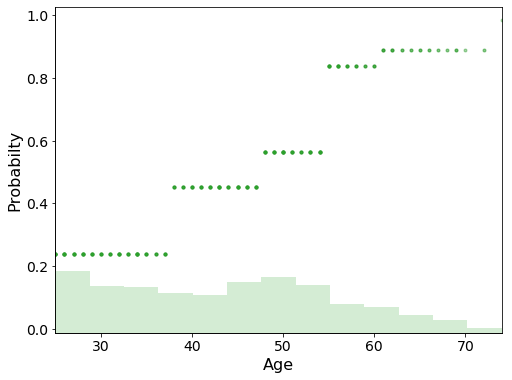

In [40]:
features = X_train
base_shap = explainer.expected_value

feat_text = 'Age'
feature_name = 'age'
shap_columns = None
shap_text = None

fig, ax = plt.subplots(1,1,figsize=(8,6))

manual_bins = None
x_quantile_min = 0.0
x_quantile_max = 1
SZ = 16
color = sns.color_palette()[2]
dep_plot(feature_name=feature_name, shap_values=shap_values, features=features, shap_columns=shap_columns, ax=None,
         feature_text=feat_text, shap_text=shap_text,
         base_shap=base_shap, y_transform='probability', add_nan=False, nan_label='NaN',
         x_min=None, x_max=None, x_round=None, manual_bins=manual_bins,
         x_quantile_min=x_quantile_min, x_quantile_max=x_quantile_max,
         plot_hist=True, plot_type=None,
         SZ=SZ, color=color, hist_color=color)